# Project 1 – Linear Programming

- MEMBERS: `Abhiroop Kumar`, `Manny Escalante`, `Simoni Dalal`, `Stiles Clements`
- GROUP NO: `G2`  
- COURSE: Optimization (R M 294)  
- DUE DATE: Due Sep 28 at 11:59pm  

## Table of Contents

1. [IMPORT CSV FILES](#import-csv-files)

2. [QUESTION 1: Data Preparation](#question-1-data-preparation)
    * [Compute returns](#compute-returns)
    * [CVaR Model Solver](#cvar-model-solver)
    * [CVaR evaluation for fixed portfolio](#cvar-evaluation-for-fixed-portfolio)
    * [Visualization_1(a): Distributions of equal-weight portfolios](#visualization_1a-distributions-of-equal-weight-portfolios)
    * [Visualization_1(b): Compare stock-level volatility across years](#visualization_1b-compare-stock-level-volatility-across-years)

3. [QUESTION 2: In-Sample Optimization (2019)](#question-2-in-sample-optimization-2019)
    * [PART A](#part-a)
    * [PART B](#part-b)
    * [Visualization 2(a): Top 10 portfolio weights for 2019](#visualization_2a-top-10-portfolio-weights-for-2019)
    * [Visualization 2(b): Compare portfolio CVaR to NDX benchmark](#visualization_2b-compare-portfolio-cvar-to-ndx-benchmark)
    * [In-sample vs out-of-sample difference](#in-sample-vs-out-of-sample-difference)

4. [QUESTION 3: Out-of-Sample Performance (2020)](#question-3-out-of-sample-performance-2020)
    * [Optimal portfolio CVaR with Beta (0.90,0.99)](#optimal-portfolio-cvar-with-beta-090099)
    * [Visualization_3(a): Top 10 portfolio weights for Beta=0.90](#visualization_3a-top-10-portfolio-weights-for-beta090)
    * [Visualization_3(b): Show how CVaR changes with confidence level](#visualization_3b-show-how-cvar-changes-with-confidence-level)

5. [QUESTION 4: Summary and Discussion](#question-4-summary-and-discussion)
    * [Optimal maximum monthly CVaR](#optimal-maximum-monthly-cvar)
    * [Minimum of the maximum monthly CVaR (2019)](#minimum-of-the-maximum-monthly-cvar-2019)
    * [Visualization_4: Monthly CVaR for both portfolios](#visualization_4-monthly-cvar-for-both-portfolios)
    * [Comparison with Part 2 (Q4)](#comparison-with-part-2-q4)

6. [QUESTION 5: Monthly Rebalancing](#question-5-monthly-rebalancing)
    * [Setup for rolling re-optimization](#setup-for-rolling-re-optimization)
    * [Monthly rolling optimization](#monthly-rolling-optimization)
    * [Summary of monthly CVaR results](#summary-of-monthly-cvar-results)
    * [Visualization 5(a): Monthly Turnover (2020)](#visualization-5a-monthly-turnover-2020)
    * [Visualization_5(b): Static vs Monthly Rebalancing Strategy](#visualization_5b-static-vs-monthly-rebalancing-strategy)
    * [Comparison with Part 2 (Q5)](#comparison-with-part-2-q5)

7. [QUESTION 6: Portfolio Stability](#question-6-portfolio-stability)
    * [Stability check on portfolios](#stability-check-on-portfolios)
    * [Enforcing Stability Constraints](#enforcing-stability-constraints)

In [1]:
# Load required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp

## Import CSV Files

> `NOTE TO PROFESSOR/TA:` Please replace the files with your own below.  

In [2]:
try:
    # Import CSV files
    data_2019 = pd.read_csv('stocks2019.csv', index_col=0, parse_dates=[0])
    data_2020 = pd.read_csv('stocks2020.csv', index_col=0, parse_dates=[0])
except FileNotFoundError:
    print("Error: The required CSV files were not found.")
    print("Please ensure the files are in the same directory as the script.")
    exit() # Exit the script if files are not found

C:\Users\Abhiroop Kumar\AppData\Local\Temp\ipykernel_17068\1692634365.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_2020 = pd.read_csv('stocks2020.csv', index_col=0, parse_dates=[0])
C:\Users\Abhiroop Kumar\AppData\Local\Temp\ipykernel_17068\1692634365.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_2020 = pd.read_csv('stocks2020.csv', index_col=0, parse_dates=[0])


### QUESTION 1: `Data Preparation`

#### Compute returns
**Explanation:** 
- Define `calculate_returns(df)` to convert all columns to numeric, drops NaNs, and compute daily percentage returns with `.pct_change()`.  
- Drop `NDX` column for portfolio construction but save its returns separately.  
- Calculate returns for 2019 and 2020.  

In [3]:
def calculate_returns(df):
    # Convert all columns to numeric
    # The `pct_change()` method will then work correctly on the numeric data
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(inplace=True)
    
    # Daily percentage returns
    returns = df.drop(columns=['NDX']).pct_change().dropna()
    # NDX returns for later analysis
    ndx_returns = df['NDX'].pct_change().dropna()
    return returns, ndx_returns

# Returns for both years
returns_2019, ndx_returns_2019 = calculate_returns(data_2019)
returns_2020, ndx_returns_2020 = calculate_returns(data_2020)

# Number of stocks (n) and time periods (q)
n = returns_2019.shape[1]
q_2019 = returns_2019.shape[0]
q_2020 = returns_2020.shape[0]

# Mean returns for 2019 data
mean_returns_2019 = returns_2019.mean(axis=0)

# Print statements to verify data loading and calculations
print("\nMean daily returns for 2019:")
print(mean_returns_2019)

print("\nFirst 5 rows of 2019 returns:")
print(returns_2019.head())

print("\nFirst 5 rows of 2020 returns:")
print(returns_2020.head())

print("\nFirst 5 daily NDX returns in 2019:")
print(ndx_returns_2019.head())

print("\nFirst 5 daily NDX returns in 2020:")
print(ndx_returns_2020.head())


Mean daily returns for 2019:
ATVI    0.001184
ADBE    0.001633
AMD     0.004097
ALXN    0.000635
ALGN    0.001696
          ...   
WBA    -0.000302
WDAY    0.000341
WDC     0.002550
XEL     0.001236
XLNX    0.000860
Length: 100, dtype: float64

First 5 rows of 2019 returns:
                ATVI      ADBE       AMD      ALXN      ALGN     GOOGL  \
X                                                                        
2019-01-03 -0.035509 -0.039498 -0.094530  0.022030 -0.085791 -0.027696   
2019-01-04  0.039903  0.048632  0.114370  0.057779  0.010445  0.051294   
2019-01-07  0.028196  0.013573  0.082632  0.018302  0.017192 -0.001994   
2019-01-08  0.030309  0.014918  0.008751  0.006207  0.015954  0.008783   
2019-01-09  0.017210  0.011819 -0.026988  0.012430  0.038196 -0.003427   

                GOOG      AMZN      AMGN       ADI  ...      TCOM      ULTA  \
X                                                   ...                       
2019-01-03 -0.028484 -0.025242 -0.015216 -0.060

#### CVaR Model Solver
**Explanation:** Minimize objective function using Gurobi.  
- Decision variables: portfolio weights `x`, VaR `alpha`, auxiliary variables `u`.  
- Objective: `alpha + (1/((1-beta)*q)) * sum(u_k)`  
- Constraints:  
    - `u_k >= -x^T y_k - alpha`  
    - `u_k >= 0`  
    - `sum(x) == 1`, `x >= 0`  
    - `x^T mean_returns >= R`  

Returns CVaR, VaR, and weights if optimal.  

> **NOTE:** This function is called in future questions.

In [4]:
def solve_cvar_model(returns_data, beta, min_return_R):    
    # Number of stocks (n) and time periods (q) from data
    n = returns_data.shape[1]
    q = returns_data.shape[0]
    
    # New Gurobi model
    model = gp.Model("CVaR_Minimization")
    model.setParam('OutputFlag', 0) # Suppress Gurobi output

    # Decision variables:
        # x: portfolio weights (n stocks)
        # alpha: VaR
        # u: auxiliary variables (q time periods)
    x = model.addMVar(n, lb=0, name="x")
    alpha = model.addMVar(1, name="alpha")
    u = model.addMVar(q, lb=0, name="u")

    # Objective function: minimize CVaR
    model.setObjective(alpha + (1 / ((1 - beta) * q)) * gp.quicksum(u), sense=gp.GRB.MINIMIZE)
    
    # Constraints: `u_k >= -x^T * y_k - alpha`
    # Using list comprehension to add all constraints at once (constraint to be enforced for each time period (k))
    model.addConstrs(u[k] >= -gp.quicksum(returns_data.iloc[k, j] * x[j] for j in range(n)) - alpha for k in range(q))

    # Portfolio constraints:
    # 1. Weights sum to 1
    model.addConstr(gp.quicksum(x) == 1)
    # 2. Minimum expected return constraint
    mean_returns = returns_data.mean(axis=0)
    model.addConstr(gp.quicksum(mean_returns[j] * x[j] for j in range(n)) >= min_return_R)
    
    # Solve model
    model.optimize()

    # Optimal solution
    if model.status == gp.GRB.OPTIMAL:
        return model.objVal, alpha.x[0], x.x
    else:
        print("No optimal solution found for the given parameters.")
        return None, None, None

#### CVaR evaluation for fixed portfolio
- **Explanation:** Calculate CVaR with fixed weights `x`.  
- **NOTE:** *Only `alpha` and `u` are optimized to compute portfolio CVaR on new datasets (e.g., out-of-sample).*  
  
> **NOTE:** This function is called in future questions.

In [5]:
def calculate_portfolio_cvar(x, returns_data, beta):
    n = returns_data.shape[1]
    q = returns_data.shape[0]
    
    model = gp.Model("CVaR_Calculation")
    model.setParam('OutputFlag', 0)

    alpha = model.addMVar(1, name="alpha")
    u = model.addMVar(q, lb=0, name="u")
    
    model.setObjective(alpha + (1 / ((1 - beta) * q)) * gp.quicksum(u), sense=gp.GRB.MINIMIZE)
    
    # Constraints: `u_k >= -x^T * y_k - alpha`
    # x is a vector from the previous optimization and can be used directly
    for k in range(q):
        portfolio_loss = -np.dot(returns_data.iloc[k, :], x)
        model.addConstr(u[k] >= portfolio_loss - alpha)

    model.optimize()

    if model.status == gp.GRB.OPTIMAL:
        return model.objVal
    else:
        print("CVaR calculation failed.")
        return None

#### Visualization_1(a): Distributions of equal-weight portfolios
- **Explanation:** Histogram comparison of daily returns from an equal-weight portfolio across all stocks in 2019 vs 2020.  
- **Relevance:** Highlights differences in distributional shape and tail risk between 2019 and 2020.  

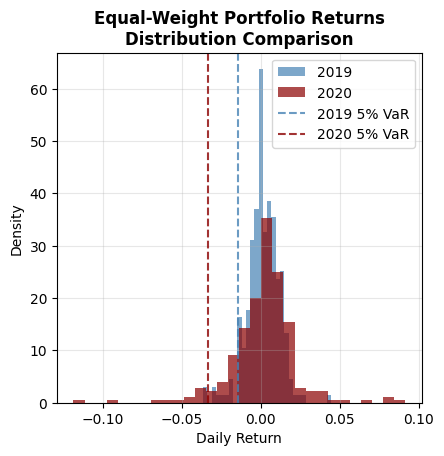

In [6]:
# Distribution Comparison
plt.figure(figsize=(16, 10))
ax2 = plt.subplot(2, 3, 2)
sample_returns_2019 = returns_2019.mean(axis=1)  # Portfolio of equal weights
sample_returns_2020 = returns_2020.mean(axis=1)
plt.hist(sample_returns_2019, bins=30, alpha=0.7, label='2019', color='steelblue', density=True)
plt.hist(sample_returns_2020, bins=30, alpha=0.7, label='2020', color='darkred', density=True)
plt.axvline(sample_returns_2019.quantile(0.05), color='steelblue', linestyle='--', alpha=0.8, label='2019 5% VaR')
plt.axvline(sample_returns_2020.quantile(0.05), color='darkred', linestyle='--', alpha=0.8, label='2020 5% VaR')
plt.title('Equal-Weight Portfolio Returns\nDistribution Comparison', fontweight='bold', fontsize=12)
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

#### Visualization_1(b): Compare stock-level volatility across years
- **Explanation:**  
    - Compute mean and standard deviation of returns for individual stocks and for NDX index in 2019.  
    - Build dataframe of annual volatilities for each stock in 2019 and 2020 (`std * sqrt(252)`).  
    - Generate scatter plot with 2019 volatilities on x-axis and 2020 volatilities on y-axis.  
- **Relevance:** Change in stock-level volatility from 2019 to 2020, relating to risk context for CVaR optimization.  


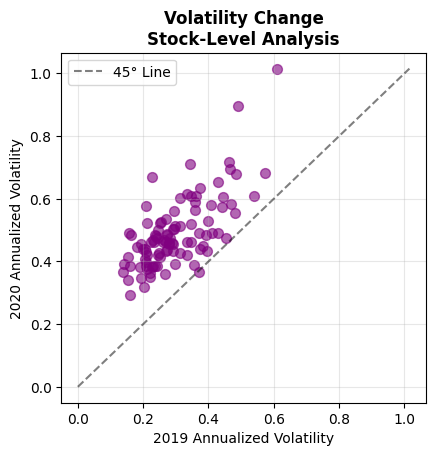

In [7]:
# Summary Statistics (for training data)
mean_returns_2019 = returns_2019.mean()
std_returns_2019 = returns_2019.std()
mean_ndx_2019 = ndx_returns_2019.mean()
std_ndx_2019 = ndx_returns_2019.std()

# Volatility Comparison
plt.figure(figsize=(16, 10))
ax3 = plt.subplot(2, 3, 3)
vol_data = pd.DataFrame({
    '2019_Vol': std_returns_2019 * np.sqrt(252),  # Annualized volatility
    '2020_Vol': returns_2020.std() * np.sqrt(252)
})
plt.scatter(vol_data['2019_Vol'], vol_data['2020_Vol'], alpha=0.6, s=50, color='purple')
max_vol = max(vol_data.max())
plt.plot([0, max_vol], [0, max_vol], 'k--', alpha=0.5, label='45° Line')
plt.xlabel('2019 Annualized Volatility')
plt.ylabel('2020 Annualized Volatility')
plt.title('Volatility Change\nStock-Level Analysis', fontweight='bold', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

### QUESTION 2: `Solve with 2019 data, evaluate on 2020 data`

In [8]:
# Declaring parameters
BETA = 0.95
MIN_RETURN_R = 0.0002 # 0.02%

#### PART A

*<u>Find the portfolio that minimizes daily average CVaR using 2019 data.</u>*

- **Purpose:** Solve CVaR with 2019 data and test on 2020.  
- **Explanation:**  
    - Call `solve_cvar_model` on 2019 returns with chosen beta and return constraint.  
    - Evaluate the same weights on 2020 using `calculate_portfolio_cvar`.  

In [9]:
cvar_2019, var_2019, x_2019 = solve_cvar_model(returns_2019, BETA, MIN_RETURN_R)
if cvar_2019 is not None:
    print(f"\nOptimal portfolio CVaR (2019 data): {cvar_2019:.6f}")
    print(f"Optimal portfolio VaR (2019 data): {var_2019:.6f}")
    
    # Evaluate the 2019 portfolio using 2020 data (out-of-sample)
    cvar_2020_outofsample = calculate_portfolio_cvar(x_2019, returns_2020, BETA)
    if cvar_2020_outofsample is not None:
        print(f"\nDaily average CVaR with 2019 portfolio in 2020: {cvar_2020_outofsample:.6f}")

Set parameter Username
Set parameter LicenseID to value 2699638
Academic license - for non-commercial use only - expires 2026-08-25


C:\Users\Abhiroop Kumar\AppData\Local\Temp\ipykernel_17068\2760708666.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.addConstr(gp.quicksum(mean_returns[j] * x[j] for j in range(n)) >= min_return_R)



Optimal portfolio CVaR (2019 data): 0.011090
Optimal portfolio VaR (2019 data): 0.008500

Daily average CVaR with 2019 portfolio in 2020: 0.046563


#### PART B

*<u>What is the cVaR of the NDX index over these time periods?</u>*

- **Purpose:** View CVaR for NDX index.  
- **Explanation:** Call `calculate_portfolio_cvar` from *Part A* with `x=[1]` on NDX return series (2019 and 2020).  

In [10]:
ndx_cvar_2019 = calculate_portfolio_cvar(np.array([1]), ndx_returns_2019.to_frame(), BETA)
ndx_cvar_2020 = calculate_portfolio_cvar(np.array([1]), ndx_returns_2020.to_frame(), BETA)
if ndx_cvar_2019 is not None and ndx_cvar_2020 is not None:
    print(f"\nNDX index CVaR (2019): {ndx_cvar_2019:.6f}")
    print(f"NDX index CVaR (2020): {ndx_cvar_2020:.6f}")


NDX index CVaR (2019): 0.024743
NDX index CVaR (2020): 0.056495


#### Visualization_2(a): Top 10 portfolio weights for 2019
**Explanation:** Top 10 weights from series indexed by stock tickers (using optimized weights `x_2019` from CVaR model), sorted in descending order.  

In [11]:
top10_2019 = (
    pd.Series(x_2019, index=returns_2019.columns, name="weight")
      .sort_values(ascending=False)
      .head(10)
)

# Pretty display in notebook
print("\nTop 10 portfolio weights for 2019:")
display(top10_2019.to_frame().style.format("{:.4%}"))

# # And/or print
# for ticker, w in top10_2019.items():
#     print(f"{ticker}: {w:.4%}")


Top 10 portfolio weights for 2019:


,weight
XEL,30.3917%
CHTR,26.4965%
AMGN,8.0766%
CTXS,6.5614%
CHKP,6.2696%
EXC,5.2155%
KHC,4.0510%
CSX,3.4312%
COST,3.0352%
EBAY,2.3486%


#### Visualization_2(b): Compare portfolio CVaR to NDX benchmark
- **Explanation:** Build side-by-side bar charts of daily 95% CVaR for the optimized portfolio and the NDX index, shown for 2019 (in-sample) and 2020 (out-of-sample).  
- **Relevance:** Highlighting how the optimized portfolio’s tail risk compares to the benchmark across years.  

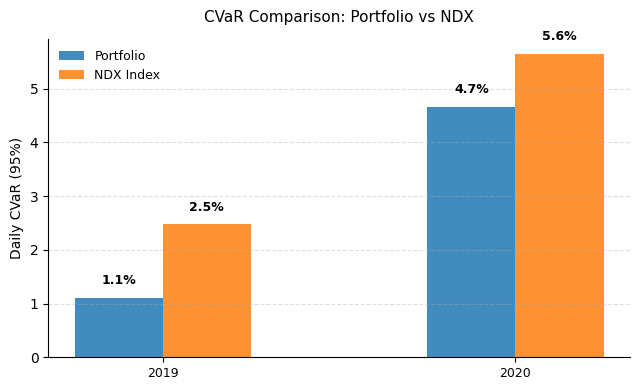

In [12]:
# Data
categories = ['2019', '2020']
portfolio_cvars = [cvar_2019 * 100, cvar_2020_outofsample * 100]
benchmark_cvars = [ndx_cvar_2019 * 100, ndx_cvar_2020 * 100]
x = np.arange(len(categories))
width = 0.25

# Plot
fig, ax = plt.subplots(figsize=(6.5, 4))
bars1 = ax.bar(x - width/2, portfolio_cvars, width, label='Portfolio',
               color='#1f77b4', alpha=0.85)
bars2 = ax.bar(x + width/2, benchmark_cvars, width, label='NDX Index',
               color='#ff7f0e', alpha=0.85)

# Value labels (bold)
for bars in (bars1, bars2):
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                f'{bar.get_height():.1f}%', ha='center', va='bottom',
                fontsize=9, fontweight='bold')

# Formatting
ax.set_ylabel('Daily CVaR (95%)', fontsize=10)
ax.set_title('CVaR Comparison: Portfolio vs NDX', fontsize=11, pad=12)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=9)
ax.legend(frameon=False, fontsize=9)
ax.spines[['top','right']].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


---

#### In-sample vs out-of-sample difference

**Question:** Briefly justify using the differences between in-sample and out-of-sample daily average CVaR, and comment on potential non-stationarity.

The 2019 data represents a **relatively normal** market period, while 2020 was a volatile year due to the COVID-19 pandemic. The portfolio optimized for 2019 CVaR may not perform well in 2020 because market conditions changed, demonstrating non-stationarity.  
  
*The out-of-sample CVaR in 2020 is <u>expected to be higher</u> as the 2019-optimized portfolio was not designed to handle the extreme conditions of 2020.*

---


### QUESTION 3: Effect of different beta values

#### Optimal portfolio CVaR with Beta (0.90,0.99)
- **Purpose:** Sensitivity analysis for beta.  
- **Explanation:** Run optimization again with `BETA=0.90` and `BETA=0.99`.  

In [13]:
BETA_90 = 0.90
BETA_99 = 0.99

# Rerun the model with beta = 0.90
cvar_90, _, x_90 = solve_cvar_model(returns_2019, BETA_90, MIN_RETURN_R)
if cvar_90 is not None:
    print(f"\nOptimal portfolio CVaR with Beta=0.90: {cvar_90:.6f}")

# Rerun the model with beta = 0.99
cvar_99, _, x_99 = solve_cvar_model(returns_2019, BETA_99, MIN_RETURN_R)
if cvar_99 is not None:
    print(f"Optimal portfolio CVaR with Beta=0.99: {cvar_99:.6f}")

C:\Users\Abhiroop Kumar\AppData\Local\Temp\ipykernel_17068\2760708666.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.addConstr(gp.quicksum(mean_returns[j] * x[j] for j in range(n)) >= min_return_R)



Optimal portfolio CVaR with Beta=0.90: 0.008900
Optimal portfolio CVaR with Beta=0.99: 0.012451


#### Visualization_3(a): Top 10 portfolio weights for Beta=0.90
**Explanation:** Extract and display top 10 portfolio weights for each beta scenario (0.90, 0.99).  

In [14]:
def top_n_df(weights, columns, n=10):
    df = pd.DataFrame({'weight': weights}, index=columns)
    return df[df['weight'] > 0].sort_values('weight', ascending=False).head(n)

# Top 10 for beta = 0.90
top10_90 = top_n_df(x_90, returns_2019.columns, 10)
print("\nTop 10 portfolio weights for Beta=0.90:")
display(top10_90.style.format({'weight': '{:.4%}'}))

# Top 10 for beta = 0.99
top10_99 = top_n_df(x_99, returns_2019.columns, 10)
print("\nTop 10 portfolio weights for Beta=0.99:")
display(top10_99.style.format({'weight': '{:.4%}'}))


Top 10 portfolio weights for Beta=0.90:


,weight
CHTR,24.0605%
XEL,21.2977%
MDLZ,13.6573%
EXC,6.4285%
WBA,5.2900%
EBAY,4.8747%
AMGN,4.7991%
CTXS,4.7285%
ORLY,4.1987%
PEP,3.1621%



Top 10 portfolio weights for Beta=0.99:


,weight
XEL,44.7035%
CHTR,24.8055%
CTXS,8.9074%
KHC,6.7269%
NTES,5.1005%
SPLK,4.6601%
AMGN,3.6309%
DXCM,0.8189%
SIRI,0.6463%


#### Visualization_3(b): Show how CVaR changes with confidence level
- **Explanation:**  Plot CVaR values (as percentages) for three confidence levels: β = 0.90, 0.95, 0.99.  
- **Relevance:** Visualize the sensitivity of portfolio risk to different confidence levels, analyzing how CVaR responds to changes in β.  

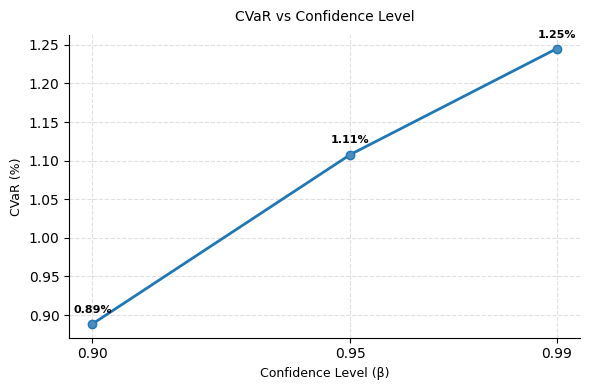

In [15]:
# Data
beta_vals = [0.90, 0.95, 0.99]
cvar_values = [0.008884, 0.011079, 0.012451]
# Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(beta_vals, [cv*100 for cv in cvar_values], 'o-',
        linewidth=2, markersize=6, color='#1F77B4', markerfacecolor='#4B8BBE')
# Labels & formatting
ax.set_xlabel('Confidence Level (β)', fontsize=9)
ax.set_ylabel('CVaR (%)', fontsize=9)
ax.set_title('CVaR vs Confidence Level', fontsize=10, pad=10)
ax.grid(True, linestyle='--', alpha=0.4)
ax.spines[['top','right']].set_visible(False)
# Set custom x-ticks
ax.set_xticks([0.90, 0.95, 0.99])
# Value annotations
for b, cv in zip(beta_vals, cvar_values):
    ax.annotate(f'{cv*100:.2f}%', xy=(b, cv*100),
                xytext=(0, 8), textcoords='offset points',
                fontsize=8, fontweight='bold', ha='center')
plt.tight_layout()
plt.show()

### QUESTION 4: `Minimizing Maximum Monthly CVaR`  

#### Optimal maximum monthly CVaR
- **Explanation:** Declare new variable `Z` representing the maximum monthly CVaR across months. 
- **Objective:** Minimize `Z` constraints to ensure each monthly CVaR ≤ `Z` (to keep portfolio weights consistent across months with expected return constraint).  

In [16]:
# Step 1: Group 2019 daily returns into months
returns_2019.index = pd.to_datetime(returns_2019.index)
monthly_returns_data = [group for name, group in returns_2019.groupby(returns_2019.index.to_period('M'))]

# Step 2: Formulate the linear program
def solve_max_monthly_cvar(monthly_data, beta, min_return_R):
    n = monthly_data[0].shape[1]
    num_months = len(monthly_data)
    
    model = gp.Model("Max_Monthly_CVaR")
    model.setParam('OutputFlag', 0)

    # Decision variables
    x = model.addMVar(n, lb=0, name="x")
    alpha_m = model.addMVar(num_months, name="alpha_m") # VaR for each month
    u_m_k = {} # Auxiliary variables for each month and day
    Z = model.addMVar(1, name="Z") # Max CVaR

    # Set objective to minimize the maximum monthly CVaR (Z)
    model.setObjective(Z, sense=gp.GRB.MINIMIZE)

    # Constraints for each month
    for m in range(num_months):
        q_m = monthly_data[m].shape[0]
        # Define auxiliary variables for the current month
        u_m_k[m] = model.addMVar(q_m, lb=0, name=f"u_{m}")

        # The CVaR for month m must be less than or equal to Z
        cvar_m_expr = alpha_m[m] + (1 / ((1 - beta) * q_m)) * gp.quicksum(u_m_k[m])
        model.addConstr(cvar_m_expr <= Z)

        # Constraints on u_m_k
        returns_month = monthly_data[m]
        for k in range(q_m):
            model.addConstr(u_m_k[m][k] >= -gp.quicksum(returns_month.iloc[k, j] * x[j] for j in range(n)) - alpha_m[m])
            
    # Overall portfolio constraints (apply to the whole year)
    model.addConstr(gp.quicksum(x) == 1)
    mean_returns_total = returns_2019.mean(axis=0)
    model.addConstr(gp.quicksum(mean_returns_total[j] * x[j] for j in range(n)) >= min_return_R)

    model.optimize()
    
    if model.status == gp.GRB.OPTIMAL:
        print(f"\nOptimal maximum monthly CVaR: {model.objVal:.6f}")
        return model.objVal, x.x
    else:
        print("No optimal solution found for Max Monthly CVaR.")
        return None, None

#### Minimum of the maximum monthly CVaR (2019)
**Explanation:** Call `solve_max_monthly_cvar` from previous cell on 2019 monthly return data.  

In [17]:
max_cvar_2019, x_max_cvar_2019 = solve_max_monthly_cvar(monthly_returns_data, BETA, MIN_RETURN_R)
if max_cvar_2019 is not None:
    print(f"Minimum of the maximum monthly CVaR (2019): {max_cvar_2019:.6f}\n")


Optimal maximum monthly CVaR: 0.012446
Minimum of the maximum monthly CVaR (2019): 0.012446



C:\Users\Abhiroop Kumar\AppData\Local\Temp\ipykernel_17068\3834097748.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.addConstr(gp.quicksum(mean_returns_total[j] * x[j] for j in range(n)) >= min_return_R)


#### Visualization_4: Monthly CVaR for both portfolios

- **Explanation:** Monthly CVaR is computed for the Daily CVaR Portfolio (`x_2019`) and the Max Monthly CVaR Portfolio (`x_max_cvar_2019`) using `calculate_portfolio_cvar()`.
- **Relevance:** Highlights why the robust max-CVaR approach is preferable under volatile or non-stationary markets.

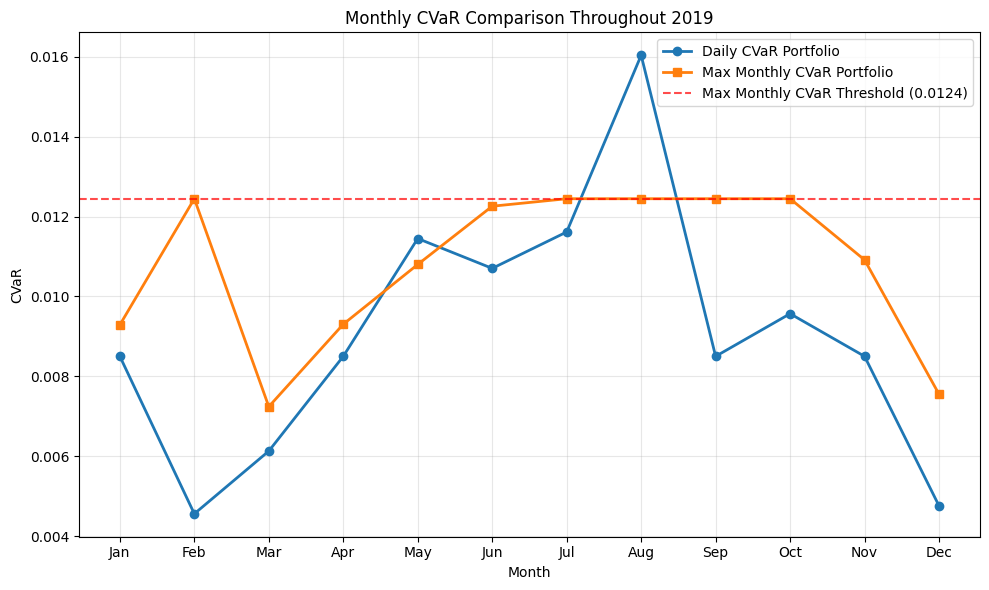

In [18]:
monthly_cvar_daily = []
monthly_cvar_max = []

for monthly_data in monthly_returns_data:
    cvar_daily = calculate_portfolio_cvar(x_2019, monthly_data, BETA)
    cvar_max = calculate_portfolio_cvar(x_max_cvar_2019, monthly_data, BETA)
    monthly_cvar_daily.append(cvar_daily)
    monthly_cvar_max.append(cvar_max)

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(10, 6))
plt.plot(months, monthly_cvar_daily, marker='o', label='Daily CVaR Portfolio', linewidth=2)
plt.plot(months, monthly_cvar_max, marker='s', label='Max Monthly CVaR Portfolio', linewidth=2)
plt.axhline(y=max_cvar_2019, color='red', linestyle='--', alpha=0.7, label=f'Max Monthly CVaR Threshold ({max_cvar_2019:.4f})')

plt.xlabel('Month')
plt.ylabel('CVaR')
plt.title('Monthly CVaR Comparison Throughout 2019')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


---

#### Comparison with Part 2 (Q4)

**Question:** Run your model again using the 2019 data with this objective. Compare with Part 2.  

Part 2 minimized the average daily CVaR over the entire year. This approach, however, minimizes the worst-case monthly CVaR. The objective value here is the CVaR of the single worst-performing month, which is likely higher than the average daily CVaR.  

*This strategy is more conservative, as it provides better protection against extreme adverse conditions in any given month.*

---


### QUESTION 5: `Monthly Rebalancing`

#### Setup for rolling re-optimization
**Explanation:**  
- Concatenate 2019 and 2020 returns into one DataFrame to allow rolling window training.  
- Initialize arrays to store monthly CVaRs, months, and portfolios.  

In [19]:
# Combine data for rolling window calculations
full_returns_df = pd.concat([returns_2019, returns_2020])

monthly_cvar_2020 = []
monthly_months_2020 = []
monthly_portfolios = []

#### Monthly rolling optimization
**Explanation:** Looping through each month of 2020. For each start date:  
- Using previous 12 months as training data.  
- Solve CVaR optimization.  
- Evaluation on that month’s data.  
    
Storing portfolio weights and CVaR per month.  

> **NOTE:** It takes time to run this code block! (ETA 1-3 mins / 4 mins in Colab)

In [20]:
# Iterate through each month in 2020
for current_month_start in pd.date_range(start='2020-01-01', end='2020-12-01', freq='MS'):
    training_start = current_month_start - pd.DateOffset(years=1)
    
    training_data = full_returns_df.loc[training_start:current_month_start - pd.Timedelta(days=1)]
    
    if training_data.empty:
        print(f"Skipping {current_month_start.strftime('%Y-%m')}: No training data.")
        continue
        
    _, _, x_new_portfolio = solve_cvar_model(training_data, BETA, MIN_RETURN_R)
    
    if x_new_portfolio is not None:
        monthly_portfolios.append(x_new_portfolio)
        
        evaluation_data = full_returns_df.loc[current_month_start:current_month_start + pd.DateOffset(months=1) - pd.Timedelta(days=1)]
        
        if evaluation_data.empty:
            print(f"Skipping evaluation for {current_month_start.strftime('%Y-%m')}: No evaluation data.")
            continue
        
        monthly_cvar = calculate_portfolio_cvar(x_new_portfolio, evaluation_data, BETA)
        print(f"Monthly CVaR for {current_month_start.strftime('%Y-%m')}: {monthly_cvar:.6f}")
        monthly_cvar_2020.append(monthly_cvar)
        monthly_months_2020.append(current_month_start.strftime('%Y-%m'))

C:\Users\Abhiroop Kumar\AppData\Local\Temp\ipykernel_17068\2760708666.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.addConstr(gp.quicksum(mean_returns[j] * x[j] for j in range(n)) >= min_return_R)


Monthly CVaR for 2020-01: 0.008140
Monthly CVaR for 2020-02: 0.035750
Monthly CVaR for 2020-03: 0.101232
Monthly CVaR for 2020-04: 0.041765
Monthly CVaR for 2020-05: 0.029995
Monthly CVaR for 2020-06: 0.026284
Monthly CVaR for 2020-07: 0.032245
Monthly CVaR for 2020-08: 0.016165
Monthly CVaR for 2020-09: 0.034410
Monthly CVaR for 2020-10: 0.023320
Monthly CVaR for 2020-11: 0.021530
Monthly CVaR for 2020-12: 0.016021


#### Summary of monthly CVaR results
**Explanation:** Compute average, variance, min, max of monthly CVaRs.  

In [21]:
# Monthly CVaR summary statistics for 2020
if monthly_cvar_2020:
    avg_cvar = np.mean(monthly_cvar_2020)
    var_cvar = np.var(monthly_cvar_2020)
    min_cvar = np.min(monthly_cvar_2020)
    max_cvar = np.max(monthly_cvar_2020)

    print(f"\nAverage daily CVaR with monthly rebalancing in 2020: {avg_cvar:.6f}")
    print(f"CVaR variation (variance): {var_cvar:.6f}")
    print(f"Minimum monthly CVaR: {min_cvar:.6f}")
    print(f"Maximum monthly CVaR: {max_cvar:.6f}\n")


Average daily CVaR with monthly rebalancing in 2020: 0.032238
CVaR variation (variance): 0.000517
Minimum monthly CVaR: 0.008140
Maximum monthly CVaR: 0.101232



#### Visualization 5(a): Monthly Turnover (2020)

- **Explanation:** *Portfolio turnover* is calculated as the L1 norm of weight changes between consecutive months, i.e., $(\sum |w_{t} - w_{t-1}|)$. The bar chart will show the shifts in portfolio composition month by month in 2020.  
- **Relevance:** Turnover measures the *cost of rebalancing* - higher values imply more trading and transaction expenses. This highlights the trade-off between maintaining a stable portfolio and frequently adjusting allocations to adapt to market volatility.

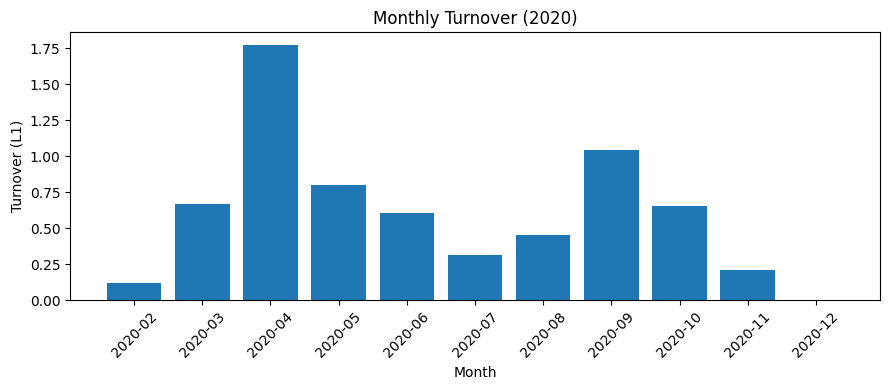

In [23]:
turnover = [np.nan]
for t in range(1, len(monthly_portfolios)):
    prev_w, curr_w = monthly_portfolios[t-1], monthly_portfolios[t]
    turnover.append(np.sum(np.abs(curr_w - prev_w)))
plt.figure(figsize=(9,4))
plt.bar(monthly_months_2020, turnover)
plt.xlabel('Month'); plt.ylabel('Turnover (L1)'); plt.title('Monthly Turnover (2020)')
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

#### Visualization_5(b): Static vs Monthly Rebalancing Strategy

- **Explanation:** Compares 2020 CVaR for a Static Portfolio (fixed 2019 weights) versus a Monthly Rebalancing strategy (re-optimized each month).
- **Relevance:** Shows that rebalancing adapts to non-stationary markets and often reduces risk, while static portfolios remain exposed to elevated volatility.

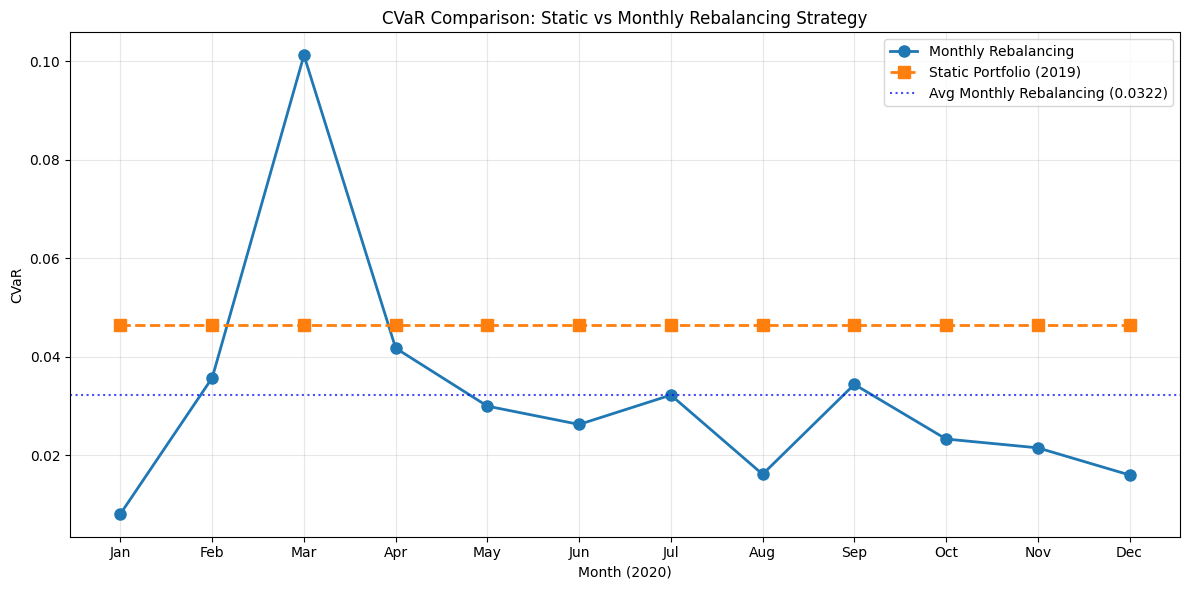

In [24]:
# Comparison data
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
static_cvar = [cvar_2020_outofsample] * 12  # Same CVaR for all months (static portfolio)

plt.figure(figsize=(12, 6))
plt.plot(months, monthly_cvar_2020, marker='o', label='Monthly Rebalancing', linewidth=2, markersize=8)
plt.plot(months, static_cvar, marker='s', label='Static Portfolio (2019)', linewidth=2, linestyle='--', markersize=8)

plt.axhline(y=np.mean(monthly_cvar_2020), color='blue', linestyle=':', alpha=0.7, label=f'Avg Monthly Rebalancing ({np.mean(monthly_cvar_2020):.4f})')

plt.xlabel('Month (2020)')
plt.ylabel('CVaR')
plt.title('CVaR Comparison: Static vs Monthly Rebalancing Strategy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


---

#### Comparison with Part 2 (Q5)

**Question:** Please evaluate the average daily CVaR, its variation and minimum and maximum monthly CVaR and then compare with Part 2. Is it worthwhile to reoptimize across months?  

Reoptimizing monthly allows the portfolio to adapt to changing market conditions. The average daily CVaR with monthly rebalancing might be lower or have less variation than the static portfolio from Part 2, especially in a volatile year like 2020.  

*This suggests it is worthwhile to reoptimize, as it allows the portfolio to adjust to non-stationary market behavior.*

---


### QUESTION 6: `Portfolio Stability`

#### Stability check on portfolios
**Explanation:** Compare monthly portfolios sequentially.  

In [25]:
is_stable = True
if len(monthly_portfolios) > 1:
    for i in range(1, len(monthly_portfolios)):
        weight_changes = np.abs(monthly_portfolios[i] - monthly_portfolios[i-1])
        if np.any(weight_changes > 0.05):
            is_stable = False
            break

if is_stable:
    print("The sequence of monthly portfolios is stable.")
else:
    print("The sequence of monthly portfolios is NOT stable.")

The sequence of monthly portfolios is NOT stable.



---

#### Enforcing Stability Constraints

**Question:** Describe how you might add constraints to the CVaR optimization model to enforce stability in portfolio weights over time.  

To enforce stability, a set of constraints can be added for each month's optimization problem.  
Let $x_{j,t}$ be the weight of stock $j$ at time %t%, and $x_{j,(t-1)}$ be its weight from the previous month's optimization.  

The stability constraints can be written as:
- $x_{j,t} - x_{j,(t-1)} \leq 0.05$
- $x_{j,(t-1)} - x_{j,t} \leq 0.05$

This can be written as $|x_{j,t} - x_{j,t-1}| \leq 0.05$. The previous month's optimal `x` would need to passed into the next month's optimization model as a fixed parameter and add these constraints.

---


# THE END